In [2]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import pandas as pd

# Selecting the simulations

In [3]:
#Number of simulation you want to load

#Periodic Simu
#simu_numbers=np.array([59,49,51,52,53,54,63,64,68,67,70,69,68,619]) #301,302,303,304,305,313,314,315,316,320,321,207
#simu_numbers=np.array([51,63,60,67,69,65,70,62,71,72,74]+[83,84,85,116,153,154,210,309,610,317,318,619])
#Non Periodic Simu
#simu_numbers=np.array([83,84,85,116,153,154,210,309,610,317,318,319,519]+[n for n in range(105,110)])
simu_numbers=np.array([83,84,116,153,154,210,317,318,319,519,922]+[n for n in range(105,110)]) #CONVERGING MORE THAN 90%



simu_name_tab=np.array([f'String {num}' for num in simu_numbers])

#Time to start the velovity field storage
tstart=-20

#Arrays where I will store the parameters:

kh_E_tab= np.zeros_like(simu_numbers,dtype='float') 
k_f_tab= np.zeros_like(simu_numbers,dtype='float')
k_beta_tab= np.zeros_like(simu_numbers,dtype='float')
Z_tab=np.zeros_like(simu_numbers,dtype='float')
KbetaOL_tab=np.zeros_like(simu_numbers,dtype='float')
Oc_tab_l=np.zeros_like(simu_numbers,dtype='float')
Zo_tab_l=np.zeros_like(simu_numbers,dtype='float')
E_zonal_tab=np.zeros_like(simu_numbers,dtype='float')
E_mean_tab=np.zeros_like(simu_numbers,dtype='float')
jet_size_tab=np.zeros_like(simu_numbers,dtype='float')
rhines_length_tab=np.zeros_like(simu_numbers,dtype='float')


f0_tab=np.zeros_like(simu_numbers,dtype='float')
beta_tab=np.zeros_like(simu_numbers,dtype='float')
hEkb_tab=np.zeros_like(simu_numbers,dtype='float')
dh_tab=np.zeros_like(simu_numbers,dtype='float')
Lx_tab=np.zeros_like(simu_numbers,dtype='float')
nx_tab=np.zeros_like(simu_numbers,dtype='float')
ny_tab=np.zeros_like(simu_numbers,dtype='float')
sigma_f_tab=np.zeros_like(simu_numbers,dtype='float')
bc_fac_tab=np.zeros_like(simu_numbers,dtype='float')
nu_hyper_tab=np.zeros_like(simu_numbers,dtype='float')
n_hyper_tab=np.zeros_like(simu_numbers,dtype='float')

E_diss_jet=np.zeros_like(simu_numbers,dtype='float')
E_diss_tot=np.zeros_like(simu_numbers,dtype='float')
Area_tot=np.zeros_like(simu_numbers,dtype='float')



#Choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file

for i,n in enumerate(simu_numbers):
    if where=='local':
        if n<10:
            simu_name='outdir_000'+str(n)
        elif n<100 and n>=10:
            simu_name='outdir_00'+str(n)
        Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

    elif where=='dahu':
        simu_name='dahu_'+str(n)
        Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'
        
    else:
        print('Error: where not recognized')
        sys.exit()
    print('la simulation chargée est: ' + simu_name + "depuis: "+where)
    
    simu_name_tab[i]=simu_name
    print(simu_name_tab)
    filenames=['/vars.nc']



    dataset=nc.Dataset(Path+filenames[0])

    #t=dataset.variables['time'][:]
    x=dataset.variables['x'][:]
    y=dataset.variables['y'][:]
    psi=dataset.variables['psi'][:,:,:,:]
    q=dataset.variables['q'][:,:,:,:]
    #print("psi shape",psi.shape)
    
    #Lecture des paramètres :

    param=io.read_params(Path)

    f0= param['f0']
    beta=param['beta']
    hEkb=param['hEkb']
    dh=param['dh'][0]
    Lx=param['Lx']
    nx=param['NX']
    ny=param['NY']
    k_f=param['k_f']
    sigma_f=param['sigma_f']
    bc_fac=param['bc_fac']
    nu_hyper=param['nu_hyper']
    n_hyper=param['n_hyper']
    dt_out=param['dt_out']

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)
    
    #Calcul de kh_E
    kh_E=np.sqrt(r**3/epsilon)
    kh_E_tab[i]=kh_E

    #Calcul de k_beta
    k_beta=(beta**3/epsilon)**(1/5)
    k_beta_tab[i]=k_beta

    k_f_tab[i]=k_f

    #computing zonostrophy:

    Z_tab[i]= (beta**2*epsilon/(r**5))**(1/20)
    print('Zonostrophie:',Z_tab[i]) 
    
    #Computing Kbeta*L
    k_betar=beta**0.5/(epsilon/r)**(1/4)
    KbetaOL_tab[i]= 1/(k_betar*Lx)

    #Computin occupation and zonostrophy by the definition
    Oc_tab_l[i]= (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L
    Zo_tab_l[i]= (beta**2*epsilon/r**5)**(1/20)

    #Storing the velocity field
    delta=Lx/nx

    u,v=op.calc_uv(psi[tstart:,0,:,:],delta,bc_fac)
    

    #Mean energy
    energy_tot=np.mean(0.5*(u**2+v**2),axis=0)

    #Energy of the mean zonal flow
    energy_zonal=0.5*(np.mean(u,axis=0)**2)

    #Energy of the mean flow
    #FALSEenergy_mean=0.5*(np.mean(np.sqrt(u**2+v**2),axis=0)**2)

    energy_mean=0.5*(np.mean(u,axis=0)**2+np.mean(v,axis=0)**2)

    ratioUzonUtot=energy_zonal/energy_tot
    ratioUmeanUtot=energy_mean/energy_tot

    E_zonal_tab[i]=np.nanmean(ratioUzonUtot, axis=(0,1)) 
    E_mean_tab[i]=np.nanmean(ratioUmeanUtot, axis=(0,1))
    print(E_zonal_tab[i],E_mean_tab[i])


    #plotting the zonnaly averaged stream function with respect to the latitude
    
    psi_zonal_mean = np.mean(psi[tstart:,0,:,:], axis=2)
    psi_zonal_mean_temp = np.mean(psi_zonal_mean, axis=0)

    
    q_zonal_mean = np.mean(q[tstart:,0,:,:], axis=2)
    q_zonal_mean_temp = np.mean(q_zonal_mean, axis=0)

    zero_crossings = np.where(np.diff(np.sign(psi_zonal_mean_temp)))[0] # Find the zero crossings

    jet_size_tab[i]=(y[zero_crossings][1]-y[zero_crossings][0]+y[zero_crossings][-1]-y[zero_crossings][-2])#/(2*Lx)
    epsilon=sigma_f**2
    rhines_length_tab[i]=np.pi*2/(beta**0.5/(epsilon/r)**(1/4))
    
    psi_max=np.max(psi_zonal_mean_temp)
    
    indices=np.arange(zero_crossings[0],zero_crossings[1]+1,1)
    #finding the indices where psi is greater than 20% of the maximum
    #indices=np.where(psi_zonal_mean_temp>0.2*psi_max)
    


    #Finding the lattitude of psi at the extremity of the jet
    #y_max=y[indices[0]]
    
    E_diss_jet[i]=-2*np.sum(energy_tot[indices,:])*r
    E_diss_tot[i]=-2*np.sum(energy_tot)*r
    Area_tot[i]=Lx**2
    

    #filling the arrays
    f0_tab[i]=f0
    beta_tab[i]=beta
    hEkb_tab[i]=hEkb
    dh_tab[i]=dh
    Lx_tab[i]=Lx
    nx_tab[i]=nx
    ny_tab[i]=ny
    sigma_f_tab[i]=sigma_f
    bc_fac_tab[i]=bc_fac
    nu_hyper_tab[i]=nu_hyper
    n_hyper_tab[i]=n_hyper
    







la simulation chargée est: dahu_83depuis: dahu
['dahu_83' 'String 84' 'String 116' 'String 153' 'String 154' 'String 210'
 'String 317' 'String 318' 'String 319' 'String 519' 'String 922'
 'String 105' 'String 106' 'String 107' 'String 108' 'String 109']


# Zonostrophy plot

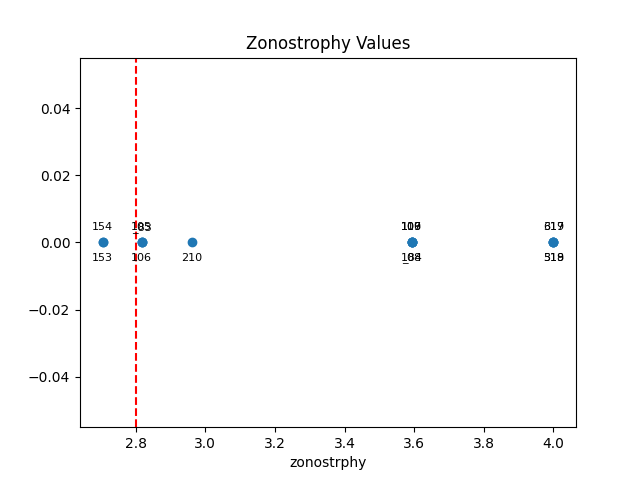

[2.70494977 2.70494977 2.81758509 2.81758509 2.81758509 2.96227541
 3.5927681  3.5927681  3.5927681  3.5927681  3.5927681  4.
 4.         4.         4.        ]


In [6]:
plt.figure()

# Plotting the scatter plot
plt.scatter(Z_tab, [0] * Z_tab.shape[0])

# Adding text above each point
for i, desc in enumerate(simu_name_tab):
    if i%2==0:

        plt.text(Z_tab[i], 0.006, desc[-3:], fontsize=8, ha='center', va='top')
    else:
        plt.text(Z_tab[i], -0.006, desc[-3:], fontsize=8, ha='center', va='bottom')

plt.xlabel('zonostrphy')
plt.title('Zonostrophy Values')
plt.axvline(x=2.8, color='r', linestyle='--')
plt.show()

print(np.sort(Z_tab))

# Parameters space

In [7]:
# x=Z_tab
# y=KbetaOL_tab

# plt.figure(figsize=(9,9))
# # Plotting the data with descriptions
# for i, desc in enumerate(simu_name_tab):
#     plt.scatter(x[i], y[i], label=desc)
#     plt.text(x[i], y[i], desc, fontsize=9, ha='left', va='bottom')


# plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$')
# plt.ylabel(r'$Oc=L_{\beta r}/L_x$')
# plt.yscale('log')

# plt.title('Espaces des paramètres de la simulation')
# plt.show()

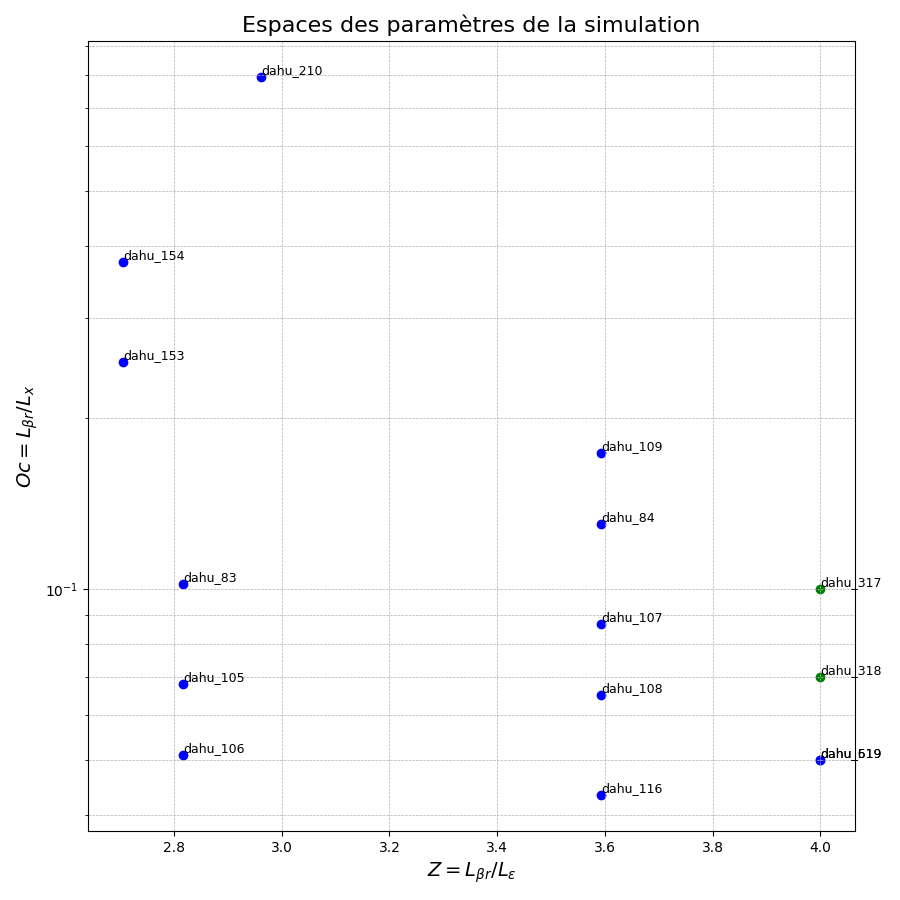

In [8]:
import matplotlib.pyplot as plt

# Assuming x, y, and simu_name_tab are already defined
x = Zo_tab_l
y = Oc_tab_l

plt.figure(figsize=(9, 9))
# Define the specific simu_name values that don't check the energy requirement
highlighted_simus = [207,301, 302, 303, 304, 305,306,321,320,611,313,314,315,316]
cool_simus=[317,318,319]
# Plotting the data with descriptions
for i, desc in enumerate(simu_name_tab):
    simu_number = int(desc.split('_')[-1])  # Extract the numerical part
    if simu_number in highlighted_simus:
        color = 'purple'
    elif simu_number in cool_simus:
        color = 'green'
    else:
        color = 'blue'

    
    plt.scatter(x[i], y[i],color=color ,marker='o')  
    plt.text(x[i], y[i], desc, fontsize=9, ha='left', va='bottom')

# Labels and title
plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$', fontsize=14)
plt.ylabel(r'$Oc=L_{\beta r}/L_x$', fontsize=14)
plt.yscale('log')

plt.title('Espaces des paramètres de la simulation', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('figures/Espace_param/param_space.png')
plt.show()


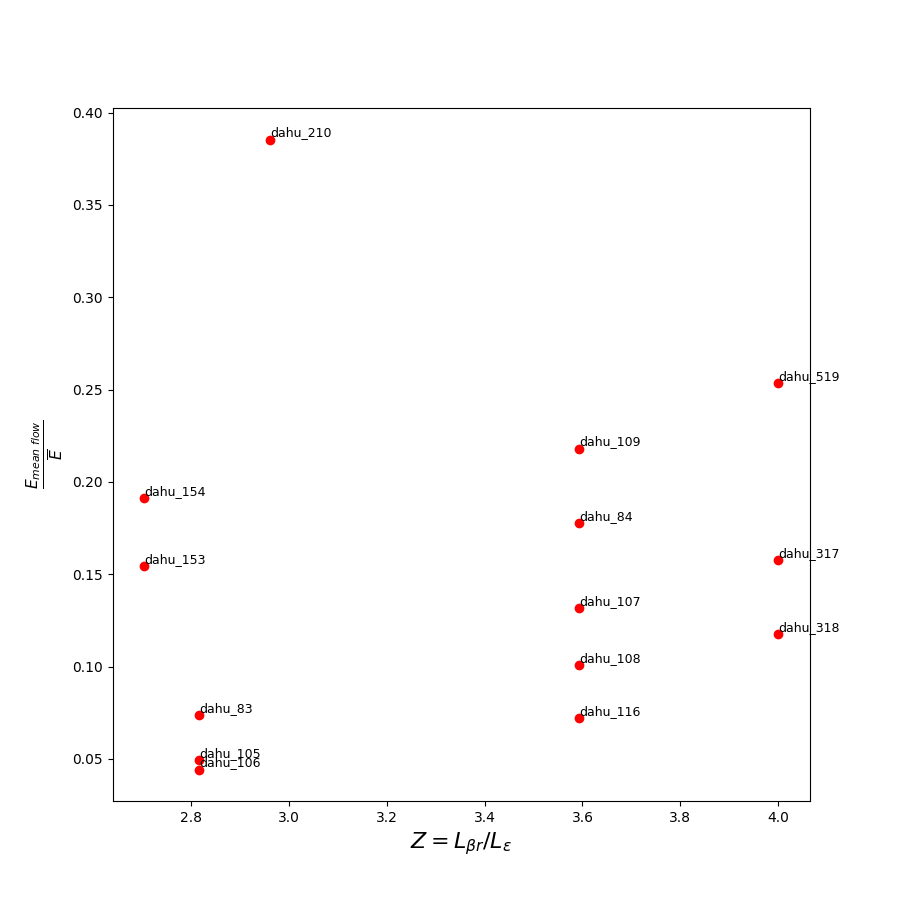

In [9]:
x=Zo_tab_l
y=E_zonal_tab
z=E_mean_tab

plt.figure(figsize=(9,9))
for i, desc in enumerate(simu_name_tab):
    simu_number = int(desc.split('_')[-1])  # Extract the numerical part
    if simu_number in highlighted_simus:
        color = 'purple'
    elif simu_number==619:
        continue
    else:
        color = 'red'

    
    plt.scatter(x[i], y[i],color=color ,marker='o')  
    plt.text(x[i], y[i], desc, fontsize=9, ha='left', va='bottom')
    #plt.scatter(x[i], z[i],color='orange' ,marker='*')

# Add the legend labels only for the representative scatter plots
plt.scatter([], [], color='red', marker='o', label='zonal mean energy ratio')
plt.scatter([], [], color='orange', marker='*', label='energy of the mean flow ratio')
#plt.legend(loc='lower right')
#plt.title('Energie ratio with respect to the zonostrophy')
plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$',fontsize=16)
plt.ylabel(r'$\frac{E_{mean\ flow}}{\overline{E}}$',fontsize=16)
plt.savefig('figures/Energy_calc/E_zonal_bc'+str(bc_fac)+'.png')
plt.show()

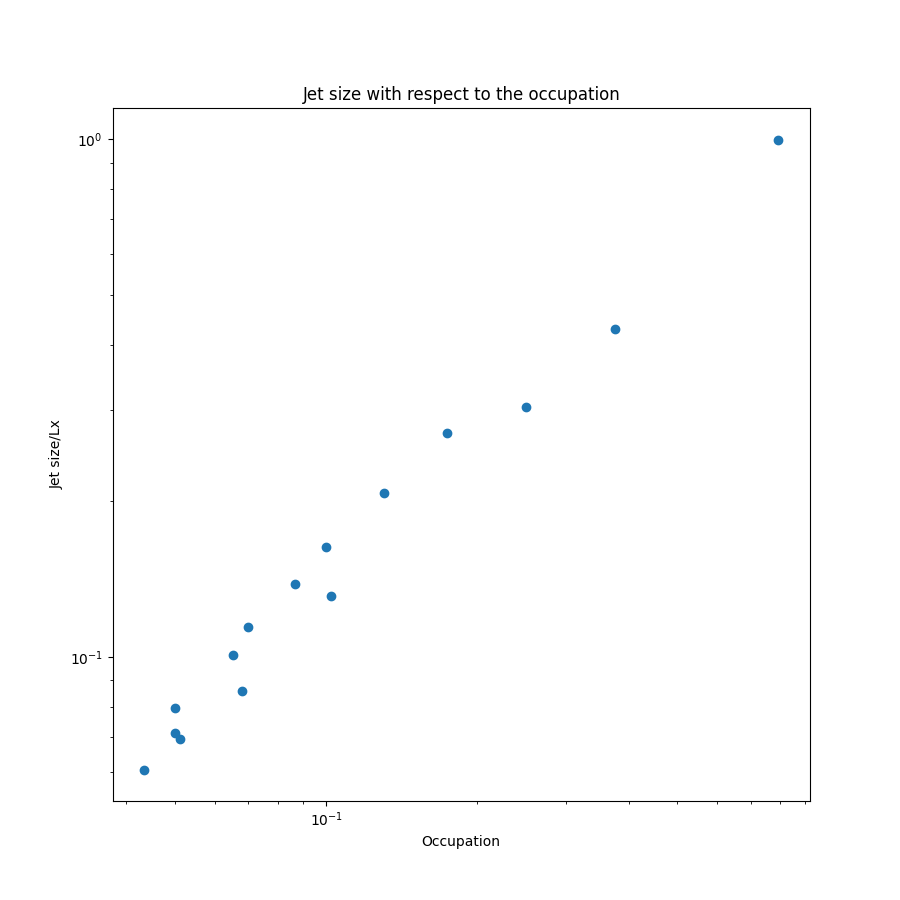

In [11]:
#Plotting the jet size VS occupation
x=Oc_tab_l
y=jet_size_tab/Lx_tab.astype(float)
#pol=np.polyfit(x,y,1)


plt.figure(figsize=(9,9))
plt.scatter(x,y,)
#plt.plot(x,pol[0]*x+pol[1],label='y='+str(pol[0])+'x+'+str(pol[1]),color='red')
plt.xlabel('Occupation')    
plt.ylabel('Jet size/Lx')
plt.loglog()
plt.title('Jet size with respect to the occupation')
plt.savefig('figures/jets/Jet_size_occupation.png')
plt.show()

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(block=None)>

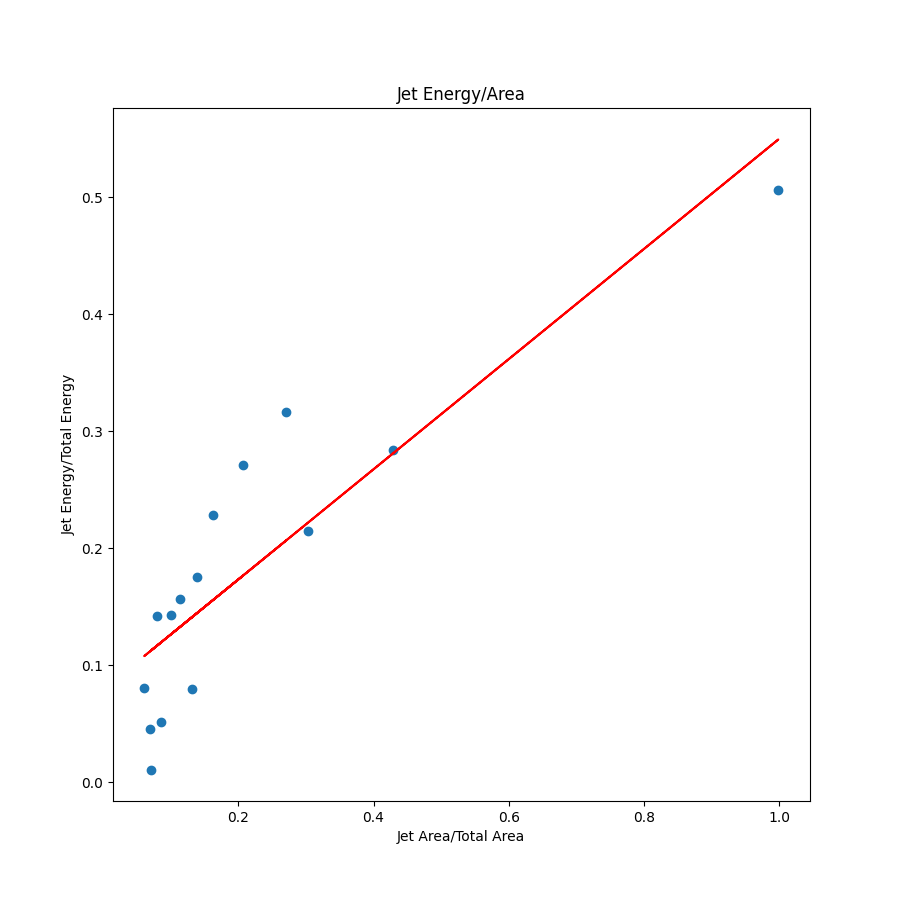

In [13]:
print(type(Lx_tab), type(jet_size_tab), type(Area_tot))
print(type(E_diss_jet), type(E_diss_tot))
x=Lx_tab.astype(float)*jet_size_tab/Area_tot#Area of the jets/total area

y=E_diss_jet/E_diss_tot #Energy dissipated by the jets/total energy dissipated

pol=np.polyfit(x,y,1)
plt.figure(figsize=(9,9))
plt.scatter(x,y)
plt.plot(x,pol[0]*x+pol[1],label='y='+str(pol[0])+'x+'+str(pol[1]),color='red')
plt.xlabel('Jet Area/Total Area')
plt.ylabel('Jet Energy/Total Energy')
plt.title('Jet Energy/Area')

plt.savefig('figures/Energy_calc/Energy_jet_area_bc'+str(bc_fac)+'.png')
plt.show

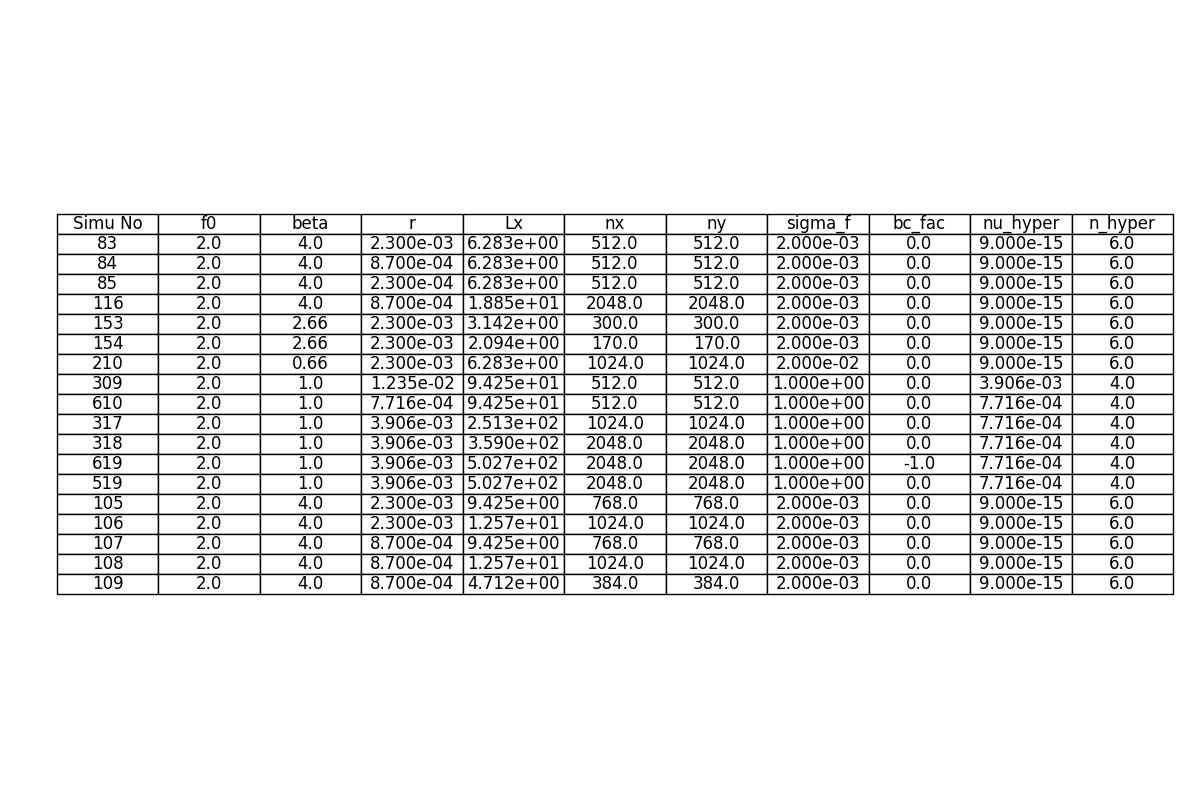

In [25]:

# Convert arrays to scientific notation with 3 significant figures
def to_sci_notation(arr):
    return np.array([f"{float(x):.3e}" for x in arr])
#f0_tab = to_sci_notation(f0_tab)
#beta_tab = to_sci_notation(beta_tab)
hEkb_tab = to_sci_notation(hEkb_tab)
dh_tab = to_sci_notation(dh_tab)
Lx_tab = to_sci_notation(Lx_tab)
#nx_tab = to_sci_notation(nx_tab)
#ny_tab = to_sci_notation(ny_tab)
sigma_f_tab = to_sci_notation(sigma_f_tab)
#bc_fac_tab = to_sci_notation(bc_fac_tab)
nu_hyper_tab = to_sci_notation(nu_hyper_tab)
#n_hyper_tab = to_sci_notation(n_hyper_tab)



# Create a DataFrame
data = {
    'Simu No': simu_numbers,
    'f0': f0_tab,
    'beta': beta_tab,
    'r': hEkb_tab,
    'Lx': Lx_tab,
    'nx': nx_tab,
    'ny': ny_tab,
    'sigma_f': sigma_f_tab,
    'bc_fac': bc_fac_tab,
    'nu_hyper': nu_hyper_tab,
    'n_hyper': n_hyper_tab
}

df = pd.DataFrame(data)

# Plot the DataFrame
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
# Save the table as a PNG image
plt.savefig('figures/simulation_parameters.png', bbox_inches='tight', pad_inches=0.1)
plt.show()